# King County Millenial homeowner program

**Buying a property in King County recommendations for Millennials**

**Authors:** Hanis Zulmuthi, Greg Burgess, Kyle Weesner

***March 2022***


<img src="https://www.condosky.com/wp-content/uploads/2019/06/Young-Families-Condos-Toronto-e1561577724820.jpg" alt="A picture of a multiracial family sitting on the floor together surrounded by moving boxes" title="" />

# Overview

King County in Washington State is growing in population made up of millenials and generation Z who either grew up or migrated to the area and found life in the region. We, the Data Analysts at the Greek Honey real estate are woking on building a model that predicts house prices in King county with the goal to help folks from the demographic to find their dream house that fits their lifestyle and their pockets! 

# ADD A SUMMARY OF RESULTS HERE

## Business Problem

Housing market in King County region, especially in the major cities such as Seattle, are becoming more and more financially inaccessible for many demographics. The demographic of interest for our real-estate is millenials who are building their career, family and trying to break into the housing market to have a stable housing for themselves. With our house price predicition model, we will help them to find the market value of their ideal house that are in proximity to city centers.

## Data Understanding

### 1. King County Housing data ([kc_house_data.csv](https://github.com/hanis-z/Phase-2-project/blob/main/data/kc_house_data.csv))
**Source:** This data was provided to us by Flatiron School. This data file is available in the project repo in the folder "data". 

**Contents:**

### 2. Incorporated & Unincorporated cities in King county
**Source:** We downloaded this data from [King County GIS website]( https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::cities-and-unincorporated-king-county-city-kc-area/explore?location=47.430582%2C-121.809200%2C10.02). The data is also easily accessible in our project repo in the folder "data".

**Contents:**

### 3. Neighborhood Map of Seattle
**Source:** We attained this data from [Seattle city GIS website](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43]). This data is also easily accessible in our project repo in the folder "data".

**Contents:**


### Importing python libraries required for the analysis.

**Note:** To ensure that all packages are loaded successfully, please ensure that you are in the right python environment. For more reference, refer the (how-to-set-environment)[link to the file] to ensure you have the correct working environment to run this notebook.

In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Define Helper Functions for Data Exploration and Cleaning

In [242]:
def dataframe_info(df):
    '''
    Takes Pandas dataframe (df). Prints number of rows, number of columns, and three sample rows.
    Returns list of numerical columns and list of non-numerical columns.
    '''
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    object_cols  = df.select_dtypes(exclude=np.number).columns.tolist()

    nrows, ncol = df.shape
    nmid = nrows // 2
    
    print(f"Dimensions: {nrows} rows and {ncol} columns")
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Object columns: {len(object_cols)}")

    display(df.iloc[[0,nmid,nrows-1]]) # show three rows: first, mid, and last

    return numeric_cols, object_cols

In [243]:
def cleaned_column_names(column_list):
    '''
    Takes list of column names (e.g. from df.columns). 
    Returns list of cleaned column names that can be assigned to DataFrame.
    Usage: df.columns = cleaned_column_names(df.columns)
    '''
    return [name.strip().lower().replace(' ','').replace('-', '_') for name in column_list]

## Data Exploration & Preparation for Linear Regression Modelling


### Load King County Housing data

In [244]:
housing_df = pd.read_csv('data/housing_gdf_complete.csv')
housing_df.columns = cleaned_column_names(housing_df.columns)

In [245]:
num, obj = dataframe_info(housing_df)

Dimensions: 21596 rows and 28 columns
Numeric columns: 17
Object columns: 11


,unnamed:0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,coord,geometry,city,dist_seattle,neighborhood,in_seattle
0,0,8856004730,9/17/2014,199950.0,2,2.75,1590,20917,1.5,NO,...,47.2786,-122.250,1310,6000,"(-122.25, 47.2786)",POINT (392815.9311460542 31962.040946318088),Algona,38586.298196,NaN,False
10798,10798,7237500590,11/17/2014,1320000.0,4,5.25,6110,10369,2.0,NO,...,47.5285,-122.135,4190,10762,"(-122.135, 47.5285)",POINT (401985.90108066204 59588.48465827319),Newcastle,19145.331588,NaN,False
21595,21595,9808100150,4/2/2015,3350000.0,5,3.75,5350,15360,1.0,NO,...,47.6480,-122.218,3740,15940,"(-122.218, 47.648)",POINT (395975.83394082234 72981.52286293103),Yarrow Point,10564.303190,NaN,False


In [246]:
print("List of numeric columns: ", num)
print("List of object columns: ", obj)

List of numeric columns:  ['unnamed:0', 'id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'dist_seattle']
List of object columns:  ['date', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'coord', 'geometry', 'city', 'neighborhood', 'in_seattle']


The original distance estimates from geopandas is in meters.

To make it more relevant, let's convert the distances to miles.

In [247]:
# convert dist_seattle from meters to miles
housing_df['dist_seattle'] = housing_df['dist_seattle'] / 1609.34

## Data Cleaning

### Basement

Creating a feature if the house has a basement or not.

In [248]:
# sqft_basement should equal difference between sqft_living and sqft_above
sqft_basement_computed = housing_df['sqft_living'] - housing_df['sqft_above']

housing_df['has_basement'] = (sqft_basement_computed > 0).astype(int)

### Yr renovated

Creating a feature of houses that have been renovated in the past 5 years.

In [249]:
housing_df['sold_dt'] = pd.to_datetime(housing_df['date']) #made a new column with date by using the pd.to_datetime()
housing_df['sold_year'] = pd.DatetimeIndex(housing_df['sold_dt']).year #made a new column year sold 
housing_df['sold_month'] = pd.DatetimeIndex(housing_df['sold_dt']).month #made a new column month sold 

In [250]:
housing_df['yr_renovated_missing'] = (housing_df['yr_renovated'].isna()).astype(int) #saving nulls for ablilty to work with
housing_df['yr_renovated'].fillna(0, inplace=True) #Rewriting dataframe filling null values with zeros

housing_df['renovated'] = ((housing_df['sold_year'] - housing_df['yr_renovated']) <= 5).astype(int) 
#houses renovated within the past 5 years

### Age of the house

Creating a feature of the age in years of the houses.

In [251]:
housing_df['house_age'] = housing_df['sold_year'] - housing_df['yr_built'] #year sold minus year built gets the age of the house
housing_df['house_age'].describe()

count    21596.000000
mean        43.323810
std         29.377864
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: house_age, dtype: float64

### View

Cleaning up missing values in the view column before using it as a feature.

In [252]:
housing_df['view_missing'] = (housing_df['view'].isna()).astype(int) #saving nulls for ablilty to work with
housing_df['view'].fillna('NONE', inplace=True) #Rewriting dataframe filling null values with NONE

### Waterfront

Cleaning up missing values in the waterfront column before using it as a feature.

In [253]:
housing_df['waterfront_missing'] = (housing_df['waterfront'].isna()).astype(int)#saving nulls for ablilty to work with
housing_df['waterfront'].fillna('NO', inplace=True) #Rewriting dataframe filling null values with NO

### Duplicate records (house resold)

Creating a feature of individual houses that were sold more than once (stated as a boolean value).

In [254]:
print(f"Number of rows:\t\t{len(housing_df['id'])}") #Total number of houses sold on id including repeats
print(f"Number unique:\t\t{len(housing_df['id'].unique())}") #First time houses being sold in this data set
print(f"Number duplicates:\t{sum(housing_df['id'].duplicated() == True)}") #houses being resold

Number of rows:		21596
Number unique:		21419
Number duplicates:	177


In [255]:
#sorting df by their dates so that resold rows come later in the dataframe
housing_df = housing_df.sort_values(by=['sold_year', 'sold_month']) 

#creates a boolean column for duplicated id of houses, then changes to int [0, 1]
housing_df['resold'] = housing_df.id.duplicated().astype(int) 

### Fill NaNs in neighborhood column

Replace NaNs with 'NA' string, to create category where Seattle neighborhood is "not applicable"

In [256]:
housing_df['neighborhood'] = housing_df['neighborhood'].fillna('NA')

### Ratio between bedrooms and bathrooms

Creating a feature of the ratio between bedrooms and bathrooms.

In [257]:
housing_df['br_bth'] = housing_df.bedrooms / housing_df.bathrooms

### Category `in_seattle`

In [258]:
housing_df['in_seattle'] = housing_df['in_seattle'].astype(int)

## Verify that columns are not collinear

### Manually remove collinear numeric columns

Manually edited columns in `relevant_num_cols` to eliminate columns correlated > 0.7 with other columns

In [259]:
relevant_num_cols = [
    'bedrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'dist_seattle',
    'has_basement',
    'yr_renovated_missing',
    'house_age',
    'view_missing',
    'waterfront_missing',
    'resold',
    'br_bth', 
    'renovated'
]

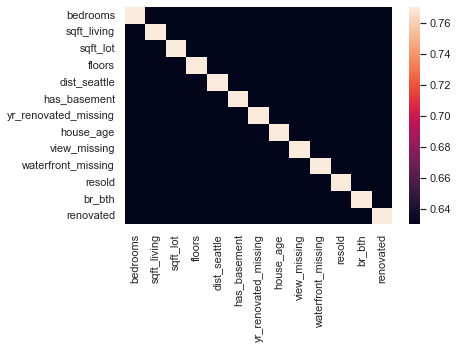

In [260]:
sns.heatmap(housing_df[relevant_num_cols].corr().abs(), vmin=.7, vmax=0.7);

### Remove collinear categorical columns

Collinearity of categorical columns will need to be verified using VIF after running statsmodels. Here, we are creating a list of categorical columns that we want to keep for our model.

In [261]:
relevant_cat_col =  [
    'waterfront',
    'zipcode',
    'view',
    'condition',
    'grade',
    'city',
    'neighborhood'
  ]

### Train test split

In [262]:
y = housing_df['price']
X = housing_df[relevant_num_cols+relevant_cat_col]

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## One Hot Encoder

In [264]:
# Version of One Hot Encoder in learn-env doesn't allow setting drop flag and handle_unknown flag simultaneously
# Be sure to choose columns to drop manually to avoid perfect collinearity
encoder = OneHotEncoder(handle_unknown='ignore',
                        categories='auto') 

# Create ColumnTransformer to transform all relevant_cat_col columns with OHE encoder
ct = ColumnTransformer(transformers=[ ('ohe', encoder, relevant_cat_col) ],
                       remainder='passthrough')

# Now that we have ct, fit it to the X_train, and apply that transformation to both X_train and X_test
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [265]:
# Put encoder output back into DataFrame for X_train and X_test
X_train = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names(), index=X_train.index)
X_test = pd.DataFrame(X_test_enc.todense(), columns= ct.get_feature_names(), index=X_test.index)

Column names in output of OHE ColumnTransformer are unwieldy. 

I'm creating a dict mapping changes from automated naming convention to something more readable.

In [266]:
replace_dict = {
    'ohe__': '',
    'x0': 'waterfront',
    'x1': 'zip',
    'x2': 'view',
    'x3': 'condition',
    'x4': 'grade',
    'x5': 'city',
    'x6': 'neighborhood'
}

In [267]:
# Use cleaned_column_names to remove spaces
X_train.columns = cleaned_column_names(X_train.columns)

for key, value in replace_dict.items():
    X_train.columns = [ x.replace(key, value) for x in list(X_train.columns) ]

In [268]:
# Use cleaned_column_names to remove spaces
X_test.columns = cleaned_column_names(X_test.columns)

for key, value in replace_dict.items():
    X_test.columns = [ x.replace(key, value) for x in list(X_test.columns) ]

In [269]:
#Separate gruop OHE columns by features

def ohe_list(string_id, col_list):
    """
    This function takes the string, search the string (that specifies feature) in the col names, 
    and group the columns together in a list
    """
    ohe_list_group = [x for x in col_list if string_id in x]
    return ohe_list_group


In [270]:
#Get ohe columns for zipcode & drop the first one
ohe_zip_cols = ohe_list('zip',X_train.columns)
ohe_zip_cols = ohe_zip_cols[1:]

#Get ohe columns for grade & drop grade 7
ohe_grade_cols = ohe_list('grade',X_train.columns)
ohe_grade_cols.remove('grade_7average')

#Get ohe columns for neighborhoods & drop na
ohe_neigh_cols = ohe_list('neighborhood',X_train.columns)
ohe_neigh_cols.remove('neighborhood_na')

#get ohe columns for view & drop none
ohe_view_cols = ohe_list('view', X_train.columns)
ohe_view_cols.remove('view_none')

## Get model metrics and validation using sklearn LinearRegression

In [271]:
def build_model(X_train, X_test, y_train, y_test):
    
    """
    Build a regression model
    
    """
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    R2_train = lr.score(X_train,y_train)
    R2_test = lr.score(X_test,y_test)


    yhat_train = lr.predict(X_train)
    train_rmse = mean_squared_error(y_train, yhat_train, squared = False)

    yhat_test = lr.predict(X_test)
    test_rmse = mean_squared_error(y_test, yhat_test, squared = False)
    
    print(f'Train R2: {lr.score(X_train,y_train)}')
    print(f'Test R2: {lr.score(X_test,y_test)}')
    print(f'Train RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')
    
    return R2_train, R2_test, train_rmse, test_rmse,yhat_test

In [272]:
model_base_cols = ['sqft_living', 'bedrooms']

Xbase_train = X_train[model_base_cols]
Xbase_test = X_test[model_base_cols]

model_base_r2_train, model_base_r2_test, train_rmse, test_rmse, yhat_test_base = build_model(Xbase_train, Xbase_test, y_train, y_test)

Train R2: 0.5077862105659563
Test R2: 0.5046145987226243
Train RMSE: 256307.8123231488
Test RMSE: 261392.48743150264


In [273]:
# drop 'grade_7average' from OHE grade cols
model_1_cols = model_base_cols + \
    ['renovated', 'house_age'] + ohe_grade_cols

X1_train = X_train[model_1_cols]
X1_test = X_test[model_1_cols]

model_1_r2_train, model_1_r2_test, train_rmse, test_rmse, yhat_test_1 = build_model(X1_train, X1_test, y_train, y_test)

Train R2: 0.6324494751299137
Test R2: 0.6452679034740165
Train RMSE: 221484.57168204186
Test RMSE: 221193.18511148528


In [274]:
model_2_cols = model_1_cols + \
    ['waterfront_yes'] + ohe_view_cols

X2_train = X_train[model_2_cols]
X2_test = X_test[model_2_cols]

model_2_r2_train, model_2_r2_test, train_rmse, test_rmse, yhat_test_2 = build_model(X2_train, X2_test, y_train, y_test)

Train R2: 0.6701765753980673
Test R2: 0.6742657553826887
Train RMSE: 209809.76820404737
Test RMSE: 211959.65737818746


In [275]:
model_3_cols = model_2_cols + \
    ['dist_seattle'] + ohe_neigh_cols

X3_train = X_train[model_3_cols]
X3_test = X_test[model_3_cols]

model_3_r2_train, model_3_r2_test, train_rmse, test_rmse, yhat_test_3= build_model(X3_train, X3_test, y_train, y_test)

Train R2: 0.7458118951408423
Test R2: 0.7474365868896222
Train RMSE: 184188.52380095117
Test RMSE: 186640.85638049926


In [276]:
model_4_cols = model_3_cols + ohe_zip_cols

X4_train = X_train[model_4_cols]
X4_test = X_test[model_4_cols]

model_4_r2_train, model_4_r2_test, train_rmse, test_rmse,yhat_test_4 = build_model(X4_train, X4_test, y_train, y_test)

Train R2: 0.833930654592211
Test R2: 0.8292800988031107
Train RMSE: 148877.71430332013
Test RMSE: 153448.82769894262


## Get human readable coefficients using statsmodels ols model summary

In [277]:
# Code borrowed from lecture slides and put into function
def make_vif(formula, df):

    y, X = dmatrices(formula, data=df, return_type='dataframe')

    # make empty VIF dataframe
    vif = pd.DataFrame()
    vif["feature"] = X.columns
  
    # calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    return vif

In [278]:
def build_ols_model(cols_list,training_df):
    
    """
    This function takes in columns list from which to build formula from and the training dataframe to build model from.
    The function then returns the model summary of an ordinary linear regression model and the formula used.
    """
    
    model_formula = 'price ~ ' + ' + '.join(cols_list)
    print(model_formula)

    model = ols(model_formula, train_df).fit()
    model_summary = model.summary()
    return model_summary, model_formula

In [279]:
train_df = pd.concat([X_train,y_train], axis=1)

In [280]:
baseline_mod_summary, base_mod_formula = build_ols_model(model_base_cols,train_df)
baseline_mod_summary

price ~ sqft_living + bedrooms


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     7462.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:06:10   Log-Likelihood:            -2.0073e+05
No. Observations:               14469   AIC:                         4.015e+05
Df Residuals:                   14466   BIC:                         4.015e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.832e+04   8014.377      9.773      0.000    6.26e+04     9.4e+04
sqft_living   312.3635      2.838    110.074      0.000     306.801     317.926
bedrooms     -5.52e+04   2787.280    -19.805      0.000   -6.07e+04   -4.97e+04
==============================================================================
Omnibus:                     9485.512   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           299522.856
Skew:                           2.682   Prob(JB):                         0.00
Kurtosis:                      24.634   Cond. No.                     8.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [281]:
model_1_summary, model_1_formula = build_ols_model(model_1_cols,train_df)
model_1_summary

price ~ sqft_living + bedrooms + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1777.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:06:10   Log-Likelihood:            -1.9862e+05
No. Observations:               14469   AIC:                         3.973e+05
Df Residuals:                   14454   BIC:                         3.974e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.042e+04   8533.169      2.393      0.017    3690.738    3.71e+04
sqft_living         178.5147      3.755     47.542      0.000     171.155     185.875
bedrooms          -2.593e+04   2507.289    -10.340      0.000   -3.08e+04    -2.1e+04
renovated          4.573e+04   2.09e+04      2.184      0.029    4678.761    8.68e+04
house_age          3276.4880     72.203     45.379      0.000    3134.961    3418.015
grade_10verygood    4.49e+05   1.06e+04     42.392      0.000    4.28e+05     4.7e+05
grade_11excellent  7.191e+05   1.68e+04     42.848      0.000    6.86e+05    7.52e+05
grade_12luxury     1.208e+06   3.09e+04     39.130      0.000    1.15e+06    1.27e+06
grade_13mansion    2.211e+06   9.25e+04     23.896      0.000    2.03e+06    2.39e+06
grade_3poor       -1.366e+05   2.22e+05     -0.616      0.538   -5.71e+05    2.98e+05
grade_4low        -1.414e+05   4.98e+04     -2.837      0.005   -2.39e+05   -4.37e+04
grade_5fair       -1.478e+05   1.84e+04     -8.038      0.000   -1.84e+05   -1.12e+05
grade_6lowaverage  -9.86e+04   7005.736    -14.074      0.000   -1.12e+05   -8.49e+04
grade_8good        1.125e+05   4944.007     22.759      0.000    1.03e+05    1.22e+05
grade_9better      2.577e+05   7393.362     34.856      0.000    2.43e+05    2.72e+05
==============================================================================
Omnibus:                     9803.526   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           451722.191
Skew:                           2.686   Prob(JB):                         0.00
Kurtosis:                      29.841   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [282]:
display(make_vif(model_1_formula, train_df))

,feature,VIF
0,Intercept,21.454666
1,sqft_living,3.494273
2,bedrooms,1.614960
3,renovated,1.009976
4,house_age,1.335793
5,grade_10verygood,1.692266
6,grade_11excellent,1.519918
7,grade_12luxury,1.218317
8,grade_13mansion,1.045282
9,grade_3poor,1.000838


In [283]:
model_2_summary, model_2_formula = build_ols_model(model_2_cols,train_df)
model_2_summary

price ~ sqft_living + bedrooms + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better + waterfront_yes + view_average + view_excellent + view_fair + view_good + view_missing


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     1468.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:06:11   Log-Likelihood:            -1.9783e+05
No. Observations:               14469   AIC:                         3.957e+05
Df Residuals:                   14448   BIC:                         3.959e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.837e+04   8117.753      4.727      0.000    2.25e+04    5.43e+04
sqft_living         158.7646      3.610     43.980      0.000     151.689     165.840
bedrooms          -1.745e+04   2386.614     -7.313      0.000   -2.21e+04   -1.28e+04
renovated          4.919e+04   1.98e+04      2.478      0.013    1.03e+04    8.81e+04
house_age          2912.7079     69.691     41.795      0.000    2776.104    3049.311
grade_10verygood    4.28e+05   1.01e+04     42.500      0.000    4.08e+05    4.48e+05
grade_11excellent  6.868e+05   1.59e+04     43.072      0.000    6.56e+05    7.18e+05
grade_12luxury     1.166e+06   2.94e+04     39.737      0.000    1.11e+06    1.22e+06
grade_13mansion     2.21e+06   8.78e+04     25.163      0.000    2.04e+06    2.38e+06
grade_3poor       -1.182e+05    2.1e+05     -0.563      0.574    -5.3e+05    2.94e+05
grade_4low        -1.407e+05   4.72e+04     -2.980      0.003   -2.33e+05   -4.82e+04
grade_5fair       -1.552e+05   1.74e+04     -8.909      0.000   -1.89e+05   -1.21e+05
grade_6lowaverage -9.784e+04   6639.466    -14.735      0.000   -1.11e+05   -8.48e+04
grade_8good        1.068e+05   4700.060     22.716      0.000    9.76e+04    1.16e+05
grade_9better      2.498e+05   7028.608     35.538      0.000    2.36e+05    2.64e+05
waterfront_yes     6.102e+05   2.57e+04     23.782      0.000     5.6e+05    6.61e+05
view_average       5.517e+04   8584.826      6.426      0.000    3.83e+04     7.2e+04
view_excellent     2.427e+05   1.75e+04     13.887      0.000    2.08e+05    2.77e+05
view_fair          1.299e+05   1.44e+04      8.988      0.000    1.02e+05    1.58e+05
view_good          1.119e+05   1.16e+04      9.658      0.000    8.92e+04    1.35e+05
view_missing       4.545e+04   3.14e+04      1.448      0.148   -1.61e+04    1.07e+05
==============================================================================
Omnibus:                     8167.027   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           287087.793
Skew:                           2.113   Prob(JB):                         0.00
Kurtosis:                      24.409   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [284]:
display(make_vif(model_2_formula, train_df))

,feature,VIF
0,Intercept,21.628580
1,sqft_living,3.597531
2,bedrooms,1.629943
3,renovated,1.010433
4,house_age,1.386236
5,grade_10verygood,1.703477
6,grade_11excellent,1.528029
7,grade_12luxury,1.226083
8,grade_13mansion,1.049506
9,grade_3poor,1.000848


In [285]:
model_3_summary, model_3_formula = build_ols_model(model_3_cols, train_df)
model_3_summary

price ~ sqft_living + bedrooms + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better + waterfront_yes + view_average + view_excellent + view_fair + view_good + view_missing + dist_seattle + neighborhood_ballard + neighborhood_beaconhill + neighborhood_capitolhill + neighborhood_cascade + neighborhood_centralarea + neighborhood_delridge + neighborhood_downtown + neighborhood_greaterduwamish + neighborhood_interbay + neighborhood_lakecity + neighborhood_magnolia + neighborhood_northcentral + neighborhood_northeast + neighborhood_northgate + neighborhood_northwest + neighborhood_queenanne + neighborhood_rainiervalley + neighborhood_sewardpark + neighborhood_universitydistrict + neighborhood_westseattle


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     1032.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:06:12   Log-Likelihood:            -1.9595e+05
No. Observations:               14469   AIC:                         3.920e+05
Df Residuals:                   14427   BIC:                         3.923e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2.743e+05   9289.561     29.532      0.000    2.56e+05    2.93e+05
sqft_living                       179.6556      3.207     56.022      0.000     173.370     185.941
bedrooms                        -1.522e+04   2112.992     -7.205      0.000   -1.94e+04   -1.11e+04
renovated                        5.112e+04   1.75e+04      2.925      0.003    1.69e+04    8.54e+04
house_age                         871.2295     70.223     12.407      0.000     733.583    1008.876
grade_10verygood                 3.216e+05   9010.802     35.695      0.000    3.04e+05    3.39e+05
grade_11excellent                5.531e+05   1.42e+04     39.006      0.000    5.25e+05    5.81e+05
grade_12luxury                   1.004e+06   2.59e+04     38.724      0.000    9.53e+05    1.05e+06
grade_13mansion                  1.938e+06   7.74e+04     25.037      0.000    1.79e+06    2.09e+06
grade_3poor                      3.005e+05   1.85e+05      1.627      0.104   -6.15e+04    6.62e+05
grade_4low                      -1.011e+04   4.16e+04     -0.243      0.808   -9.16e+04    7.14e+04
grade_5fair                      -3.99e+04   1.54e+04     -2.584      0.010   -7.02e+04   -9627.688
grade_6lowaverage               -3.328e+04   5990.640     -5.555      0.000    -4.5e+04   -2.15e+04
grade_8good                      5.579e+04   4216.056     13.234      0.000    4.75e+04    6.41e+04
grade_9better                    1.662e+05   6330.048     26.263      0.000    1.54e+05    1.79e+05
waterfront_yes                   6.322e+05   2.26e+04     28.012      0.000    5.88e+05    6.76e+05
view_average                     5.582e+04   7582.743      7.361      0.000     4.1e+04    7.07e+04
view_excellent                   2.433e+05   1.54e+04     15.793      0.000    2.13e+05    2.74e+05
view_fair                        1.022e+05   1.28e+04      7.986      0.000    7.71e+04    1.27e+05
view_good                        1.203e+05   1.02e+04     11.750      0.000       1e+05     1.4e+05
view_missing                     4.855e+04   2.76e+04      1.760      0.078   -5511.871    1.03e+05
dist_seattle                    -1.439e+04    320.761    -44.856      0.000    -1.5e+04   -1.38e+04
neighborhood_ballard             2.843e+04   1.06e+04      2.679      0.007    7625.444    4.92e+04
neighborhood_beaconhill         -1.427e+05   1.41e+04    -10.119      0.000    -1.7e+05   -1.15e+05
neighborhood_capitolhill         2.087e+05   1.46e+04     14.270      0.000     1.8e+05    2.37e+05
neighborhood_cascade              6.44e+04   3.52e+04      1.827      0.068   -4689.026    1.33e+05
neighborhood_centralarea         2.352e+04   1.12e+04      2.105      0.035    1622.321    4.54e+04
neighborhood_delridge           -1.264e+05   1.08e+04    -11.716      0.000   -1.48

In [286]:
display(make_vif(model_3_formula, train_df) )

,feature,VIF
0,Intercept,36.697902
1,sqft_living,3.678522
2,bedrooms,1.655383
3,renovated,1.015121
4,house_age,1.823627
5,grade_10verygood,1.767417
6,grade_11excellent,1.565583
7,grade_12luxury,1.238997
8,grade_13mansion,1.055847
9,grade_3poor,1.002349


In [287]:
model_4_summary, model_4_formula = build_ols_model(model_4_cols, train_df)
model_4_summary

price ~ sqft_living + bedrooms + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better + waterfront_yes + view_average + view_excellent + view_fair + view_good + view_missing + dist_seattle + neighborhood_ballard + neighborhood_beaconhill + neighborhood_capitolhill + neighborhood_cascade + neighborhood_centralarea + neighborhood_delridge + neighborhood_downtown + neighborhood_greaterduwamish + neighborhood_interbay + neighborhood_lakecity + neighborhood_magnolia + neighborhood_northcentral + neighborhood_northeast + neighborhood_northgate + neighborhood_northwest + neighborhood_queenanne + neighborhood_rainiervalley + neighborhood_sewardpark + neighborhood_universitydistrict + neighborhood_westseattle + zip_98002 + zip_98003 + zip_98004 + zip_98005 + zip_98006 + zip_98007 + zip_98008 + zip_98010 + zip_98011 + zip_98014 + zip_98019 + zip_98022 + zip_98023 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     655.5
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:06:15   Log-Likelihood:            -1.9287e+05
No. Observations:               14469   AIC:                         3.860e+05
Df Residuals:                   14358   BIC:                         3.868e+05
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        1.344e+05   2.37e+04      5.661      0.000    8.79e+04    1.81e+05
sqft_living                       162.9804      2.643     61.665      0.000     157.800     168.161
bedrooms                        -9913.7394   1731.273     -5.726      0.000   -1.33e+04   -6520.220
renovated                        6.254e+04   1.42e+04      4.407      0.000    3.47e+04    9.04e+04
house_age                         552.6228     59.103      9.350      0.000     436.773     668.473
grade_10verygood                 2.454e+05   7572.133     32.407      0.000    2.31e+05     2.6e+05
grade_11excellent                4.363e+05   1.17e+04     37.217      0.000    4.13e+05    4.59e+05
grade_12luxury                   8.309e+05   2.13e+04     38.979      0.000    7.89e+05    8.73e+05
grade_13mansion                  1.798e+06   6.31e+04     28.501      0.000    1.67e+06    1.92e+06
grade_3poor                      1.508e+05    1.5e+05      1.005      0.315   -1.43e+05    4.45e+05
grade_4low                       2.041e+04   3.38e+04      0.603      0.546   -4.59e+04    8.67e+04
grade_5fair                     -1.086e+04   1.27e+04     -0.857      0.391   -3.57e+04     1.4e+04
grade_6lowaverage               -8094.5794   4960.089     -1.632      0.103   -1.78e+04    1627.835
grade_8good                      2.884e+04   3518.439      8.198      0.000    2.19e+04    3.57e+04
grade_9better                    1.127e+05   5293.851     21.298      0.000    1.02e+05    1.23e+05
waterfront_yes                   6.426e+05   1.86e+04     34.515      0.000    6.06e+05    6.79e+05
view_average                     6.764e+04   6250.140     10.822      0.000    5.54e+04    7.99e+04
view_excellent                   2.835e+05   1.27e+04     22.406      0.000    2.59e+05    3.08e+05
view_fair                        6.988e+04   1.05e+04      6.671      0.000    4.94e+04    9.04e+04
view_good                        1.454e+05   8427.654     17.257      0.000    1.29e+05    1.62e+05
view_missing                     5.287e+04   2.24e+04      2.361      0.018    8967.533    9.68e+04
dist_seattle                    -7948.8852    956.263     -8.312      0.000   -9823.284   -6074.487
neighborhood_ballard             5.934e+04   2.02e+04      2.943      0.003    1.98e+04    9.89e+04
neighborhood_beaconhill         -5.248e+04   2.78e+04     -1.885      0.059   -1.07e+05    2085.835
neighborhood_capitolhill         5950.6572   3.66e+04      0.163      0.871   -6.57e+04    7.76e+04
neighborhood_cascade            -1.352e+04   5.15e+04     -0.263      0.793   -1.14e+05    8.74e+04
neighborhood_centralarea        -2.463e+04   3.05e+04     -0.809      0.419   -8.43e+04    3.51e+04
neighborhood_delridge            1.222e+04   2.44e+04      0.501      0.616   -3.56

In [288]:
display(make_vif(model_4_formula, train_df) )

,feature,VIF
0,Intercept,365.194430
1,sqft_living,3.806136
2,bedrooms,1.692847
3,renovated,1.019735
4,house_age,1.967802
...,...,...
106,zip_98177,3.008586
107,zip_98178,3.169131
108,zip_98188,1.634851
109,zip_98198,2.006712


## Data Visualization

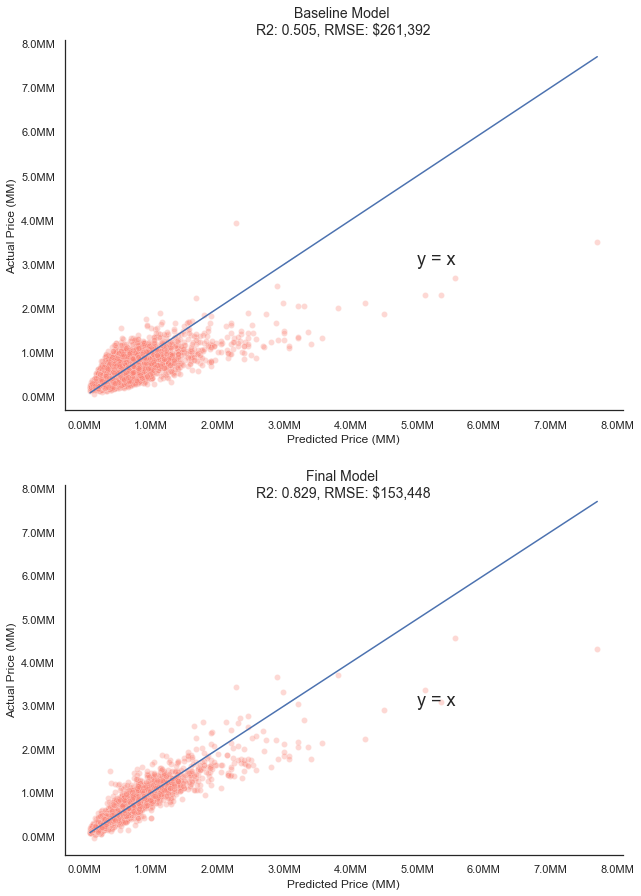

In [289]:
#Plot average prediction error
fig, ax = plt.subplots (2,1,figsize = (10,15))

sns.set_theme(style = 'white')

ax1 = sns.scatterplot(x=y_test, y=yhat_test_base, ax = ax[0], color = 'salmon', alpha = 0.3)
sns.lineplot(x=y_test, y=y_test, ax = ax[0])

ax2 = sns.scatterplot(x=y_test, y=yhat_test_4, ax = ax[1], color = 'salmon', alpha = 0.3)
sns.lineplot(x=y_test, y=y_test, ax = ax[1])

x_label = 'Predicted Price (MM)'
y_label = 'Actual Price (MM)'
tick_labels = ['{:,.1f}'.format(x) + 'MM' for x in ax1.get_xticks()/1000000]
ax1.set_xticklabels(tick_labels)
ax2.set_xticklabels(tick_labels)
ax1.set_yticklabels(tick_labels)
ax2.set_yticklabels(tick_labels)

ax1.set_xlabel(x_label)
ax2.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax2.set_ylabel(y_label)

ax1.set_title('Baseline Model \nR2: 0.505, RMSE: $261,392',fontsize = 14)
ax2.set_title('Final Model \nR2: 0.829, RMSE: $153,448', fontsize = 14, loc = 'center',y=0.95)

ax1.annotate('y = x', xy =(5000000,3000000), fontsize = 18)
ax2.annotate('y = x', xy =(5000000,3000000), fontsize = 18)


sns.despine()

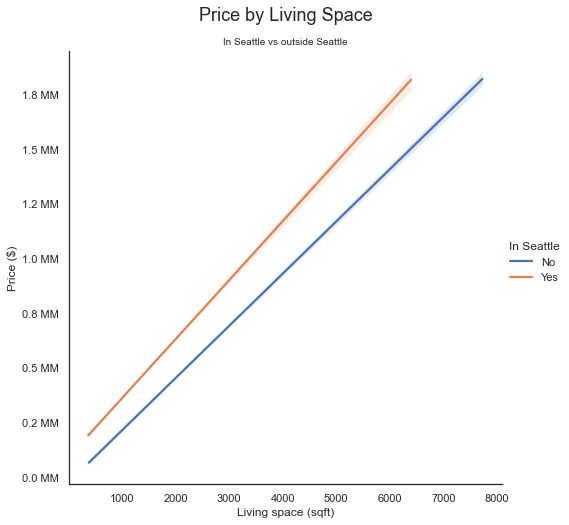

In [290]:

# # fig, ax = plt.subplots(ncols = 2,)
# f, ax = plt.subplots(1, 2)

g = sns.lmplot(x='sqft_living', y='price', hue = 'in_seattle',data=housing_df[housing_df['price']<2000000], scatter = False,facet_kws={'legend_out': True},height = 7)
# ax1.set_xlabel ('Living space (sqft)')
# ax1.set_ylabel('Price')


# plt.figure(figsize = (15,20))
plt.xlabel("Living space (sqft)")
plt.ylabel("Price ($)")
plt.title('In Seattle vs outside Seattle', y=1, fontsize=10)
plt.suptitle('Price by Living Space',y=1.04,fontsize = 18)
# title
new_title = 'In Seattle'
g._legend.set_title(new_title)
# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
# plt.ticklabel_format(style='plain', axis='y');
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{(y/1000000):.1f} MM'))

plt.savefig('Images/price_by_living_space.jpg',bbox_inches="tight",dpi=300)
plt.savefig('Images/price_by_living_space.png',bbox_inches="tight",dpi=300)

plt.show(g)

The figure for median house price by neighborhood in Seattle is plotted in the notebook ***add_city_neighborhood.ipynb*** , available in our repo. For any interest in geospatial processing done in this project, please refer to the following notebook.

<img src='Images/mean_price_by_neighborhood_map.png' alt="Figure of Median house price by neighborhood in Seattle" title="Median house price by neighborhood in Seattle" />

<img src='Images/property_price_map.jpg' alt="Figure of property price across King county, Washington" title="Property price across King county, Washington" />

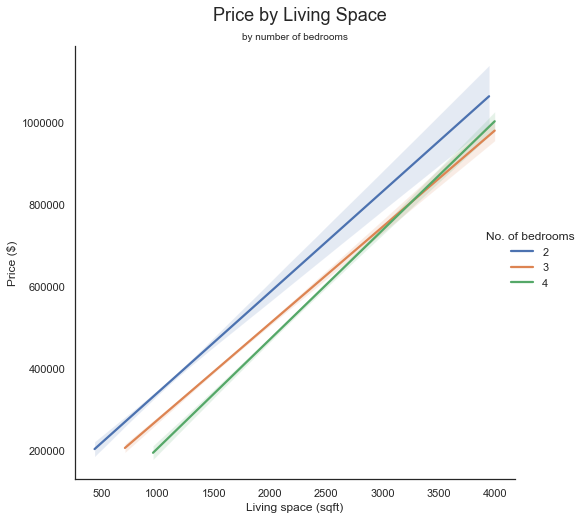

In [217]:
filt = (train_df['bedrooms'].isin([2,3,4])) & (train_df['price'] <= 2000000) & (train_df['sqft_living'] <=4000)
cleaner_train_df = train_df[filt]
cleaner_train_df['price'] = cleaner_train_df['price']

g=sns.lmplot(y='price', x='sqft_living', hue='bedrooms', data=cleaner_train_df, scatter=False, facet_kws={'legend_out': True}, height = 7)
plt.xlabel("Living space (sqft)")
plt.ylabel("Price ($)")
plt.title('by number of bedrooms', y=1, fontsize=10)
plt.suptitle('Price by Living Space',y=1.03,fontsize = 18)
# title
new_title = 'No. of bedrooms'
g._legend.set_title(new_title)
# replace labels
new_labels = ['2','3','4']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
plt.ticklabel_format(style='plain', axis='y');

plt.savefig('Images/lmplot_price-vs-sqft_living-by_bedrooms.jpg', transparent = False, bbox_inches="tight");

In [219]:
# Probably could have done this differently, but just needed a way to order and plot the levels of grade
cleaner_train_df['grade_ordinal'] = (cleaner_train_df['grade_3poor']       * 3) + \
                                    (cleaner_train_df['grade_4low']        * 4) + \
                                    (cleaner_train_df['grade_5fair']       * 5) + \
                                    (cleaner_train_df['grade_6lowaverage'] * 6) + \
                                    (cleaner_train_df['grade_7average']    * 7) + \
                                    (cleaner_train_df['grade_8good']       * 8) + \
                                    (cleaner_train_df['grade_9better']     * 9) + \
                                    (cleaner_train_df['grade_10verygood']  * 10) + \
                                    (cleaner_train_df['grade_11excellent'] * 11) + \
                                    (cleaner_train_df['grade_12luxury']    * 12) + \
                                    (cleaner_train_df['grade_13mansion']   * 13)

In [220]:
cleaner_train_df['grade_ordinal']

16715     9.0
128       7.0
8422      7.0
1221      8.0
8228      7.0
         ... 
3357      7.0
20873    10.0
13889     6.0
11092     8.0
3288      6.0
Name: grade_ordinal, Length: 12668, dtype: float64

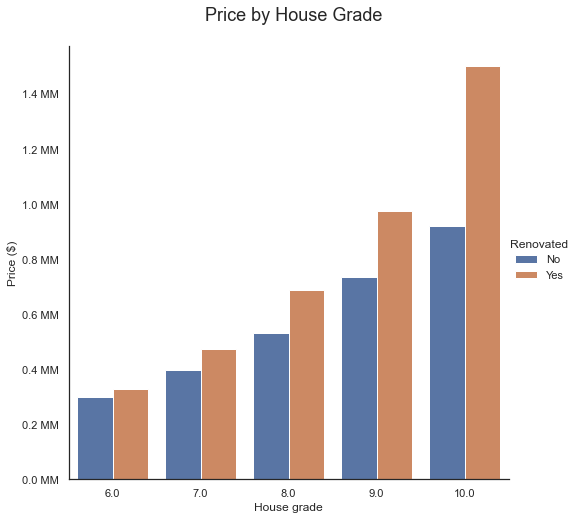

In [240]:
filt = (cleaner_train_df['grade_ordinal'] >= 6) & (cleaner_train_df['grade_ordinal'] <= 10)

import matplotlib.ticker as tkr

ax1 = sns.catplot(x="grade_ordinal", y="price", hue="renovated", kind="bar", data=cleaner_train_df[filt], ci=None, height = 7, legend_out=True)

plt.xlabel("House grade")
plt.ylabel("Price ($)")
# plt.title('by number of bedrooms', y=1, fontsize=10)
plt.suptitle('Price by House Grade',y=1.03,fontsize = 18)

new_title = 'Renovated'
ax1._legend.set_title(new_title)
# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(ax1._legend.texts, new_labels):
    t.set_text(l)

for ax in ax1.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{(y/1000000):.1f} MM'))
# plt.ticklabel_format(style='plain', axis='y');

plt.savefig('Images/barplot_price-vs-grade-by-renovated.jpg', transparent = False, bbox_inches="tight");